# Finetuning FakeNewsAAAI
FakeNewsAAAI is a Fake News dataset with 2 possible labels: `real` and `fake`

In [1]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
import torch.nn as nn
import torch.multiprocessing as mp
from tqdm import tqdm
import pickle
from copy import deepcopy
from multiprocessing import Pool                                                

from transformers import BertForSequenceClassification, RobertaForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer
from utils.forward_fn import forward_mask_sequence_classification
from utils.metrics import classification_metrics_fn
from utils.data_utils import FakeNewsDataset, FakeNewsDataLoader
from utils.utils import generate_random_mask

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.4f}'.format(key, value))
    return ' '.join(string_list)

In [3]:
def influence_score(model, id, subword, mask, label, device='cpu'):
    loss_fct = CrossEntropyLoss(reduction='none')
    with torch.no_grad():
        # Prepare input & label
        subword = torch.LongTensor(subword)
        mask = torch.FloatTensor(mask)
        label = torch.LongTensor(label)

        if device == "cuda":
            subword = subword.cuda()
            mask = mask.cuda()
            label = label.cuda()

        if isinstance(model, BertForSequenceClassification):
            # Apply mask
            weight, bias = model.classifier.weight, model.classifier.bias
            dropout_mask = generate_random_mask([id], weight.shape[0], weight.shape[1], device=device).repeat(subword.shape[0],1,1)
            masked_weight = weight.expand_as(dropout_mask) * dropout_mask

            # Calculate latents
            latents = model.bert(subword, attention_mask=mask)[1]
            latents = model.dropout(latents)            
        elif isinstance(model, RobertaForSequenceClassification):
            # Apply mask
            weight, bias = model.classifier.out_proj.weight, model.classifier.out_proj.bias
            dropout_mask = generate_random_mask([id], weight.shape[0], weight.shape[1], device=device).repeat(subword.shape[0],1,1)
            masked_weight = weight.expand_as(dropout_mask) * dropout_mask

            # Calculate latents
            latents = model.roberta(subword, attention_mask=mask)[0][:,0,:]
            latents = model.classifier.dense(latents)
            latents = model.classifier.dropout(latents)
        else:
            ValueError(f'Model class `{type(model)}` is not implemented yet')

        # Compute loss with mask
        logits = torch.einsum('bd,bcd->bc', latents, masked_weight) + bias
        mask_loss = loss_fct(logits.view(-1, model.num_labels), label.view(-1))

        # Compute loss with flipped mask
        logits = torch.einsum('bd,bcd->bc', latents, (masked_weight.max() - masked_weight)) + bias
        flipped_mask_loss = loss_fct(logits.view(-1, model.num_labels), label.view(-1))
                              
        return flipped_mask_loss - mask_loss
                              
def build_influence_matrix(model, data_loader, train_size, device='cpu'):
    test_size, batch_size = len(data_loader.dataset), data_loader.batch_size
    influence_mat = torch.zeros(test_size, train_size, device=device)
    idx2id = {}
    for i, batch_data in enumerate(data_loader):
        print(f'Processing batch {i+1}/{len(data_loader)}')
        (ids, subword_batch, mask_batch, label_batch, seq_list) = batch_data
        token_type_batch = None

        for train_idx in tqdm(range(train_size)):
            train_id = train_idx + 1
            scores = influence_score(model, train_id, subword_batch, mask_batch, label_batch, device=device)
            for j, id in enumerate(ids):
                idx2id[(i * batch_size) + j] = id
                influence_mat[(i * batch_size) + j, train_idx] = scores[j]
    return influence_mat, idx2id

def get_inference_result(model, data_loader, device='cpu'):
    results = {}
    with torch.no_grad():
        pbar = tqdm(data_loader, leave=True, total=len(data_loader))
        for i, batch_data in enumerate(pbar):
            batch_id = batch_data[0]
            batch_seq = batch_data[-1]
            outputs = forward_mask_sequence_classification(model, batch_data[:-1], i2w=i2w, apply_mask=True, device='cuda')
            loss, batch_hyp, batch_label, logits, label_batch = outputs

            for i, id in enumerate(batch_id):
                results[id] = batch_hyp[i] == batch_label[i]
    return results

def get_filtered_dataloader(data_loader, id_list, inclusive=True, batch_size=8, shuffle=False):
    df = data_loader.dataset.data
    if inclusive:
        filt_df = df[df['id'].isin(id_list)].reset_index(drop=True)
    else:
        filt_df = df[~df['id'].isin(id_list)].reset_index(drop=True)
    dataset = FakeNewsDataset(dataset_path=None, dataset=filt_df, tokenizer=tokenizer, lowercase=False)
    data_loader = FakeNewsDataLoader(dataset=dataset, max_seq_len=512, batch_size=batch_size, num_workers=8, shuffle=shuffle)  
    return data_loader

In [4]:
# Set random seed
set_seed(26092020)

# Set mp start method
mp.set_start_method('spawn')

# Load Model

In [5]:
# Load Tokenizer and Config
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
config = AutoConfig.from_pretrained('roberta-base')
config.num_labels = FakeNewsDataset.NUM_LABELS

# Instantiate model
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', config=config)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [6]:
count_param(model)

124647170

# Prepare Dataset

In [7]:
train_dataset_path = './data/train.tsv'
valid_dataset_path = './data/valid.tsv'
# test_dataset_path = './dataset/test.tsv'

In [8]:
train_dataset = FakeNewsDataset(dataset_path=train_dataset_path, tokenizer=tokenizer, lowercase=False)
valid_dataset = FakeNewsDataset(dataset_path=valid_dataset_path, tokenizer=tokenizer, lowercase=False)
# test_dataset = FakeNewsDataset(dataset_path=test_dataset_path, tokenizer=tokenizer, lowercase=False)

train_loader = FakeNewsDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=8, num_workers=8, shuffle=True)  
valid_loader = FakeNewsDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=8, num_workers=8, shuffle=False)  
# test_loader = FakeNewsDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=8, num_workers=8, shuffle=False)

In [9]:
w2i, i2w = FakeNewsDataset.LABEL2INDEX, FakeNewsDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'fake': 0, 'real': 1}
{0: 'fake', 1: 'real'}


# Fine Tuning & Evaluation

In [10]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)
model = model.cuda()

In [11]:
# Train
n_epochs = 10
best_val_metric, best_metrics, best_state_dict = 0, None, None
early_stop, count_stop = 3, 0
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        outputs = forward_mask_sequence_classification(model, batch_data[:-1], i2w=i2w, apply_mask=True, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = classification_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        outputs = forward_mask_sequence_classification(model, batch_data[:-1], i2w=i2w, apply_mask=True, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = classification_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = classification_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    # Early stopping
    val_metric = metrics['F1']
    if best_val_metric <= val_metric:
        best_state_dict = model.state_dict().copy()
        best_val_metric = val_metric
        best_metrics = metrics
        count_stop = 0
    else:
        count_stop += 1
        if count_stop == early_stop:
            break
            
print('== BEST METRICS ==')
print(metrics_to_string(best_metrics))

# Save best model
for k, v in best_state_dict.items():
    best_state_dict[k] = v.cpu()
torch.save(best_state_dict, './tmp/model_weight.pt')

# Load best model
model.load_state_dict(best_state_dict)

  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 1) TRAIN LOSS:0.2179 ACC:0.9030 F1:0.9025 REC:0.9016 PRE:0.9045 LR:0.00001000


VALID LOSS:0.0955 ACC:0.9687 F1:0.9685 REC:0.9677 PRE:0.9702: 100%|██████████| 268/268 [00:38<00:00,  6.89it/s]
  0%|          | 0/788 [00:00<?, ?it/s]

(Epoch 1) VALID LOSS:0.0955 ACC:0.9687 F1:0.9685 REC:0.9677 PRE:0.9702


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.0701 ACC:0.9752 F1:0.9752 REC:0.9750 PRE:0.9754 LR:0.00001000


VALID LOSS:0.0812 ACC:0.9691 F1:0.9690 REC:0.9681 PRE:0.9707: 100%|██████████| 268/268 [00:39<00:00,  6.82it/s]
  0%|          | 0/788 [00:00<?, ?it/s]

(Epoch 2) VALID LOSS:0.0812 ACC:0.9691 F1:0.9690 REC:0.9681 PRE:0.9707


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.0145 ACC:0.9956 F1:0.9955 REC:0.9955 PRE:0.9956 LR:0.00001000


VALID LOSS:0.0960 ACC:0.9724 F1:0.9723 REC:0.9722 PRE:0.9725: 100%|██████████| 268/268 [00:39<00:00,  6.85it/s]
  0%|          | 0/788 [00:00<?, ?it/s]

(Epoch 3) VALID LOSS:0.0960 ACC:0.9724 F1:0.9723 REC:0.9722 PRE:0.9725


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.0055 ACC:0.9986 F1:0.9986 REC:0.9985 PRE:0.9986 LR:0.00001000


VALID LOSS:0.1451 ACC:0.9705 F1:0.9705 REC:0.9705 PRE:0.9705: 100%|██████████| 268/268 [00:38<00:00,  6.89it/s]
  0%|          | 0/788 [00:00<?, ?it/s]

(Epoch 4) VALID LOSS:0.1451 ACC:0.9705 F1:0.9705 REC:0.9705 PRE:0.9705


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0131 ACC:0.9965 F1:0.9965 REC:0.9964 PRE:0.9966 LR:0.00001000


VALID LOSS:0.1011 ACC:0.9687 F1:0.9686 REC:0.9689 PRE:0.9684: 100%|██████████| 268/268 [00:38<00:00,  6.89it/s]
  0%|          | 0/788 [00:00<?, ?it/s]

(Epoch 5) VALID LOSS:0.1011 ACC:0.9687 F1:0.9686 REC:0.9689 PRE:0.9684


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 6) TRAIN LOSS:0.0124 ACC:0.9959 F1:0.9959 REC:0.9958 PRE:0.9959 LR:0.00001000


VALID LOSS:0.1053 ACC:0.9771 F1:0.9770 REC:0.9765 PRE:0.9777: 100%|██████████| 268/268 [00:40<00:00,  6.64it/s]
  0%|          | 0/788 [00:00<?, ?it/s]

(Epoch 6) VALID LOSS:0.1053 ACC:0.9771 F1:0.9770 REC:0.9765 PRE:0.9777


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 7) TRAIN LOSS:0.0053 ACC:0.9987 F1:0.9987 REC:0.9987 PRE:0.9987 LR:0.00001000


VALID LOSS:0.1128 ACC:0.9724 F1:0.9724 REC:0.9723 PRE:0.9724: 100%|██████████| 268/268 [00:59<00:00,  4.51it/s] 
  0%|          | 0/788 [00:00<?, ?it/s]

(Epoch 7) VALID LOSS:0.1128 ACC:0.9724 F1:0.9724 REC:0.9723 PRE:0.9724


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 8) TRAIN LOSS:0.0048 ACC:0.9984 F1:0.9984 REC:0.9984 PRE:0.9984 LR:0.00001000


VALID LOSS:0.1238 ACC:0.9762 F1:0.9761 REC:0.9758 PRE:0.9765: 100%|██████████| 268/268 [00:39<00:00,  6.87it/s]
  0%|          | 0/788 [00:00<?, ?it/s]

(Epoch 8) VALID LOSS:0.1238 ACC:0.9762 F1:0.9761 REC:0.9758 PRE:0.9765


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 9) TRAIN LOSS:0.0115 ACC:0.9973 F1:0.9973 REC:0.9973 PRE:0.9973 LR:0.00001000


VALID LOSS:0.1086 ACC:0.9752 F1:0.9751 REC:0.9744 PRE:0.9764: 100%|██████████| 268/268 [00:39<00:00,  6.78it/s]


(Epoch 9) VALID LOSS:0.1086 ACC:0.9752 F1:0.9751 REC:0.9744 PRE:0.9764
== BEST METRICS ==
ACC:0.9771 F1:0.9770 REC:0.9765 PRE:0.9777


<All keys matched successfully>

In [12]:
# # Evaluate on test
# model.eval()
# torch.set_grad_enabled(False)

# total_loss, total_correct, total_labels = 0, 0, 0
# list_hyp, list_label = [], []

# pbar = tqdm(test_loader, leave=True, total=len(test_loader))
# for i, batch_data in enumerate(pbar):
#     _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
#     list_hyp += batch_hyp

# # Save prediction
# df = pd.DataFrame({'label':list_hyp}).reset_index()
# df.index = df.index + 1
# df.to_csv('prediction.csv')

# print(df)

# Calculate Influence

# Influence score on incorrectly classified data

In [ ]:
%%time
(ids, subword_batch, mask_batch, label_batch, seq_list) = batch_data
influence_score(model, ids[0], subword_batch, mask_batch, label_batch, device='cuda')

In [ ]:
%%time
results = get_inference_result(model, valid_loader, device='cuda')
correct_list = list(map(lambda kv: kv[0], filter(lambda kv: kv[1], results.items())))
incorrect_list = list(map(lambda kv: kv[0], filter(lambda kv: not kv[1], results.items())))

In [ ]:
filt_valid_loader = get_filtered_dataloader(valid_loader, incorrect_list, batch_size=16)
len(valid_loader), len(filt_valid_loader), len(valid_loader.dataset), len(filt_valid_loader.dataset)

In [ ]:
%%time
influence_matrix, idx2id = build_influence_matrix(model, filt_valid_loader, len(train_loader.dataset), device='cuda')

In [ ]:
np.save('influence_matrix.npy', (influence_matrix, idx2id))

# Influence score on all validation data

In [13]:
# Save data per chunk to file
n_chunks = 6
chunk_size = (valid_loader.dataset.data.shape[0] // n_chunks) + 1
chunk_data, models = [], []

df = pd.read_csv('./data/valid.tsv', sep='\t')
for i in range(n_chunks):
    df.loc[i * chunk_size:(i+1) * chunk_size,:].to_csv(f'./tmp/chunk_{i}.tsv', sep='\t', index=False)

In [14]:
# # NOT SURE WHY IT IS NOT WORKING
# # Process chunk in parallel
# processes = (
#     'CUDA_VISIBLE_DEVICES=1 /home/samuel/anaconda2/envs/env_py3.7/bin/python build_influence_matrix.py --valid_dataset_path ./tmp/chunk_0.tsv --model_path ./tmp/model_weight.pt --index 0 > log_0.log', 
#     'CUDA_VISIBLE_DEVICES=2 /home/samuel/anaconda2/envs/env_py3.7/bin/python build_influence_matrix.py --valid_dataset_path ./tmp/chunk_1.tsv --model_path ./tmp/model_weight.pt --index 1 > log_1.log', 
#     'CUDA_VISIBLE_DEVICES=3 /home/samuel/anaconda2/envs/env_py3.7/bin/python build_influence_matrix.py --valid_dataset_path ./tmp/chunk_2.tsv --model_path ./tmp/model_weight.pt --index 2 > log_2.log', 
#     'CUDA_VISIBLE_DEVICES=4 /home/samuel/anaconda2/envs/env_py3.7/bin/python build_influence_matrix.py --valid_dataset_path ./tmp/chunk_3.tsv --model_path ./tmp/model_weight.pt --index 3 > log_3.log', 
#     'CUDA_VISIBLE_DEVICES=5 /home/samuel/anaconda2/envs/env_py3.7/bin/python build_influence_matrix.py --valid_dataset_path ./tmp/chunk_4.tsv --model_path ./tmp/model_weight.pt --index 4 > log_4.log', 
#     'CUDA_VISIBLE_DEVICES=6 /home/samuel/anaconda2/envs/env_py3.7/bin/python build_influence_matrix.py --valid_dataset_path ./tmp/chunk_5.tsv --model_path ./tmp/model_weight.pt --index 5 > log_5.log'
# )

# def run_process(process):
#     os.system(process)

# pool = Pool(processes=6)
# pool.map(run_process, processes)

In [86]:
# Aggregate result
influence_matrices, id_list = [], []
for i in range(6):
    (influence_matrix, idx2id_chunk) = np.load(f"./tmp/influence_matrix_{i}.npy", allow_pickle=True)
    influence_matrices.append(influence_matrix.cpu().numpy())
    for k in range(len(idx2id_chunk)):
        id_list.append(idx2id_chunk[k])

In [88]:
influence_matrix = np.concatenate(influence_matrices, axis=0)
influence_matrix.shape

(2144, 6299)

In [89]:
np.save('./tmp/influence_matrix_all.npy', (influence_matrix, idx2id))

/home/samuel/anaconda2/envs/env_py3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


# Qualitative analysis influence

In [75]:
%%time
model = model.cuda()
results = get_inference_result(model, valid_loader, device='cuda')
correct_list = list(map(lambda kv: kv[0], filter(lambda kv: kv[1], results.items())))
incorrect_list = list(map(lambda kv: kv[0], filter(lambda kv: not kv[1], results.items())))

100%|██████████| 268/268 [00:37<00:00,  7.23it/s]

CPU times: user 6.72 s, sys: 1.75 s, total: 8.48 s
Wall time: 37.1 s


In [76]:
filt_valid_loader = get_filtered_dataloader(valid_loader, incorrect_list, batch_size=16)
len(valid_loader), len(filt_valid_loader), len(valid_loader.dataset), len(filt_valid_loader.dataset)

(268, 4, 2139, 53)

In [79]:
train_df = train_loader.dataset.data
valid_df = valid_loader.dataset.data
filt_valid_df = filt_valid_loader.dataset.data

In [92]:
indices = influence_matrix.argmin(axis=-1)
for id, tid in zip([i for i in range(len(indices))], indices):
    filt_valid_df.loc[filt_valid_df['id'] == id, 'tid'] = tid

In [97]:
train_df.columns = ['tid','t_tweet', 't_label']

train_df['ts_tweet'] = train_df['t_tweet'].apply(lambda x: tokenizer.tokenize(x))
filt_valid_df['s_tweet'] = filt_valid_df['tweet'].apply(lambda x: tokenizer.tokenize(x))

merged_df = filt_valid_df.merge(train_df, on='tid', how='inner')

In [99]:
merged_df['matched_subwords'] = merged_df.apply(lambda row: list(set(row['s_tweet']).intersection(set(row['ts_tweet']))), axis='columns')

In [100]:
import json
json.dump(merged_df[['tweet', 't_tweet', 's_tweet', 'ts_tweet', 'matched_subwords']].to_dict(orient='instance'), open('merged_all.json', 'w'))

In [101]:
merged_df

,id,tweet,label,tid,s_tweet,t_tweet,t_label,ts_tweet,matched_subwords
0,14,Tomorrow April 6 we will pass 10000 coronaviru...,1,638.0,"[Tomorrow, ĠApril, Ġ6, Ġwe, Ġwill, Ġpass, Ġ100...",Our total number of confirmed cases is now 116...,1,"[Our, Ġtotal, Ġnumber, Ġof, Ġconfirmed, Ġcases...","[Ġdeaths, .]"
1,50,A coronavirus vaccine: Where does it stand? Ex...,0,638.0,"[A, Ġcoron, av, irus, Ġvaccine, :, ĠWhere, Ġdo...",Our total number of confirmed cases is now 116...,1,"[Our, Ġtotal, Ġnumber, Ġof, Ġconfirmed, Ġcases...","[., Ġof]"
2,1433,More and more as Coronavirus 19 was created by...,0,638.0,"[More, Ġand, Ġmore, Ġas, ĠCor, on, av, irus, Ġ...",Our total number of confirmed cases is now 116...,1,"[Our, Ġtotal, Ġnumber, Ġof, Ġconfirmed, Ġcases...","[Ġand, Ġis, .]"
3,1508,PM @ScottMorrisonMP recently said a #COVID19 v...,0,638.0,"[PM, Ġ@, Scott, Mor, rison, MP, Ġrecently, Ġsa...",Our total number of confirmed cases is now 116...,1,"[Our, Ġtotal, Ġnumber, Ġof, Ġconfirmed, Ġcases...","[Ġto, .]"
4,1587,A @Target spokesperson said the company plans ...,0,638.0,"[A, Ġ@, Target, Ġspokesperson, Ġsaid, Ġthe, Ġc...",Our total number of confirmed cases is now 116...,1,"[Our, Ġtotal, Ġnumber, Ġof, Ġconfirmed, Ġcases...","[ĠThe, Ġto, ., Ġare]"
5,1766,A list of medical exports is causing a lot of ...,0,638.0,"[A, Ġlist, Ġof, Ġmedical, Ġexports, Ġis, Ġcaus...",Our total number of confirmed cases is now 116...,1,"[Our, Ġtotal, Ġnumber, Ġof, Ġconfirmed, Ġcases...","[Ġis, ., Ġof]"
6,2087,In a presser @VP Pence just gave two important...,1,638.0,"[In, Ġa, Ġpress, er, Ġ@, VP, ĠPence, Ġjust, Ġg...",Our total number of confirmed cases is now 116...,1,"[Our, Ġtotal, Ġnumber, Ġof, Ġconfirmed, Ġcases...","[., Ġof, Ġto, Ġnow, Ġtotal, Ġnumber, Ġare]"
7,146,There is no evidence that children have died b...,0,3152.0,"[There, Ġis, Ġno, Ġevidence, Ġthat, Ġchildren,...",Snap analysis of this: it is a relief that Cal...,1,"[Snap, Ġanalysis, Ġof, Ġthis, :, Ġit, Ġis, Ġa,...","[., Ġof, Ġa, Ġis, Ġhas, Ġthat]"
8,231,No one should have to pay for coronavirus trea...,0,3152.0,"[No, Ġone, Ġshould, Ġhave, Ġto, Ġpay, Ġfor, Ġc...",Snap analysis of this: it is a relief that Cal...,1,"[Snap, Ġanalysis, Ġof, Ġthis, :, Ġit, Ġis, Ġa,...",[.]
9,306,The Canadian government has not enacted a law ...,0,3152.0,"[The, ĠCanadian, Ġgovernment, Ġhas, Ġnot, Ġena...",Snap analysis of this: it is a relief that Cal...,1,"[Snap, Ġanalysis, Ġof, Ġthis, :, Ġit, Ġis, Ġa,...","[., Ġof, Ġa, Ġthose, Ġhas, Ġthat]"


# Analyse influence

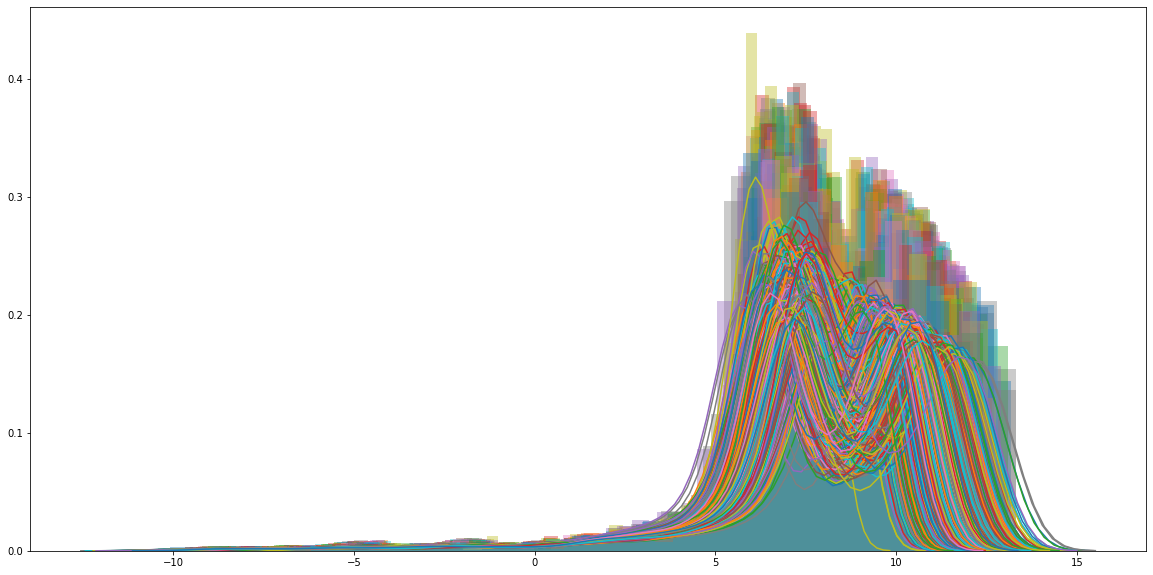

CPU times: user 3min 34s, sys: 2.31 s, total: 3min 36s
Wall time: 3min 36s


In [103]:
%%time
plt.figure(figsize=(20,10))
ax = plt.gca()
for i in range(influence_matrix.shape[1]):
    sns.distplot(influence_matrix[:,i], ax=ax)
    if i == 1000:
        break
plt.savefig('influence_dist_all.png')
plt.show()

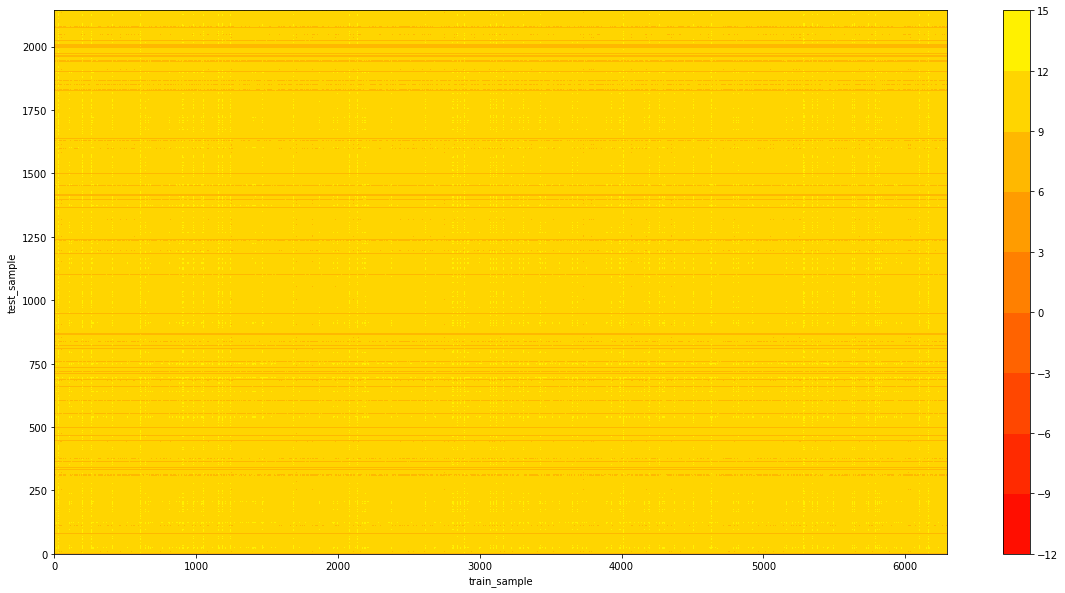

CPU times: user 20.1 s, sys: 474 ms, total: 20.6 s
Wall time: 20.6 s


In [104]:
%%time
plt.figure(figsize=(20,10))
plt.contourf(influence_matrix, cmap='autumn')
plt.colorbar()
plt.xlabel('train_sample')
plt.ylabel('test_sample')
plt.savefig('influence_all.png')
plt.show()

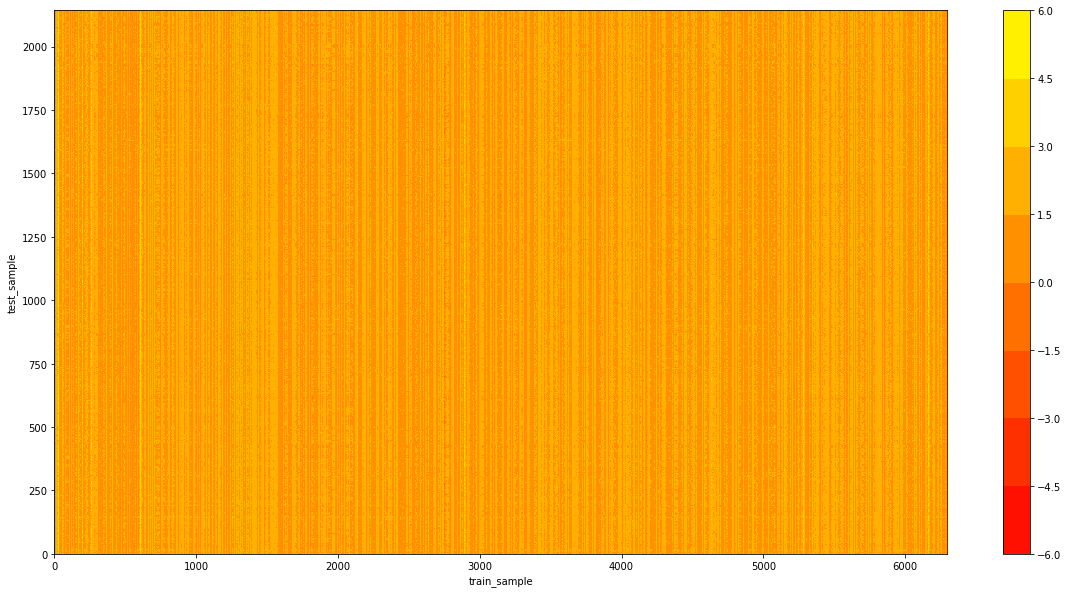

CPU times: user 37.4 s, sys: 769 ms, total: 38.2 s
Wall time: 38.2 s


In [105]:
%%time
plt.figure(figsize=(20,10))
mat = influence_matrix
mat = (mat - mat.mean(axis=-1, keepdims=True)) / mat.std(axis=-1, keepdims=True)
plt.contourf(mat, cmap='autumn')
plt.colorbar()
plt.xlabel('train_sample')
plt.ylabel('test_sample')
plt.savefig('influence_norm_all.png')
plt.show()

# Data cleansing

In [107]:
values, indices = torch.FloatTensor(influence_matrix.sum(axis=0)).sort()

In [108]:
n_elmt = indices.shape[0]
percentages = np.arange(0, 1, 0.01) + 0.01
index_percent_list = {f'{np.round(p, 2):.2f}' : indices[:int(n_elmt / (1 / p))] for p in percentages}

In [109]:
pickle.dump(index_percent_list, open('./tmp/index_percent_list_all.pkl','wb'))

# Retraining per percentage

In [111]:
index_percent_list = pickle.load(open('./tmp/index_percent_list_all.pkl','rb'))

In [112]:
[(k, len(v)) for k,v in index_percent_list.items()][:20]

[('0.01', 62),
 ('0.02', 125),
 ('0.03', 188),
 ('0.04', 251),
 ('0.05', 314),
 ('0.06', 377),
 ('0.07', 440),
 ('0.08', 503),
 ('0.09', 566),
 ('0.10', 629),
 ('0.11', 692),
 ('0.12', 755),
 ('0.13', 818),
 ('0.14', 881),
 ('0.15', 944),
 ('0.16', 1007),
 ('0.17', 1070),
 ('0.18', 1133),
 ('0.19', 1196),
 ('0.20', 1259)]

In [113]:
train_dataset = FakeNewsDataset(dataset_path=train_dataset_path, tokenizer=tokenizer, lowercase=False)
valid_dataset = FakeNewsDataset(dataset_path=valid_dataset_path, tokenizer=tokenizer, lowercase=False)

train_loader = FakeNewsDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=8, num_workers=8, shuffle=True)  
valid_loader = FakeNewsDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=8, num_workers=8, shuffle=False)

In [ ]:
stat_results = {}
for percentage in [0.01, 0.02, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.98, 0.99]:
    filt_indices = index_percent_list[f'{percentage:.2f}']
    print(f'== Retraining with {percentage * 100}% cleansing (remove {len(filt_indices)} samples) ==')
    
    # Set random seed
    set_seed(26092020)
    
    # Load Tokenizer and Config
    tokenizer = AutoTokenizer.from_pretrained('roberta-base')
    config = AutoConfig.from_pretrained('roberta-base')
    config.num_labels = FakeNewsDataset.NUM_LABELS

    # Instantiate model
    model = AutoModelForSequenceClassification.from_pretrained('roberta-base', config=config)
    
    # Data Loader
    filt_train_loader = get_filtered_dataloader(train_loader, filt_indices, inclusive=False, batch_size=8, shuffle=True)
    
    # Prepare for training
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    model = model.cuda()
    
    # Train
    n_epochs = 10
    best_val_metric, best_metrics, best_state_dict = 0, None, None
    early_stop, count_stop = 3, 0
    for epoch in range(n_epochs):
        model.train()
        torch.set_grad_enabled(True)

        total_train_loss = 0
        list_hyp, list_label = [], []

        train_pbar = tqdm(filt_train_loader, leave=True, total=len(filt_train_loader))
        for i, batch_data in enumerate(train_pbar):
            # Forward model
            outputs = forward_mask_sequence_classification(model, batch_data[:-1], i2w=i2w, apply_mask=True, device='cuda')
            loss, batch_hyp, batch_label, logits, label_batch = outputs

            # Update model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tr_loss = loss.item()
            total_train_loss = total_train_loss + tr_loss

            # Calculate metrics
            list_hyp += batch_hyp
            list_label += batch_label

            train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
                total_train_loss/(i+1), get_lr(optimizer)))

        # Calculate train metric
        metrics = classification_metrics_fn(list_hyp, list_label)
        print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
        
        # Evaluate on validation
        model.eval()
        torch.set_grad_enabled(False)

        total_loss, total_correct, total_labels = 0, 0, 0
        list_hyp, list_label = [], []

        pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
        for i, batch_data in enumerate(pbar):
            batch_seq = batch_data[-1]        
            outputs = forward_mask_sequence_classification(model, batch_data[:-1], i2w=i2w, apply_mask=True, device='cuda')
            loss, batch_hyp, batch_label, logits, label_batch = outputs

            # Calculate total loss
            valid_loss = loss.item()
            total_loss = total_loss + valid_loss

            # Calculate evaluation metrics
            list_hyp += batch_hyp
            list_label += batch_label
            metrics = classification_metrics_fn(list_hyp, list_label)

            pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

        metrics = classification_metrics_fn(list_hyp, list_label)
        print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
            total_loss/(i+1), metrics_to_string(metrics)))

        # Early stopping
        val_metric = metrics['F1']
        if best_val_metric <= val_metric:
            best_state_dict = model.state_dict().copy()
            best_val_metric = val_metric
            best_metrics = metrics
            count_stop = 0
        else:
            count_stop += 1
            if count_stop == early_stop:
                break
    # Store best result
    print(f'Evaluation with {percentage * 100}% cleansing (remove {len(filt_indices)} samples) {metrics_to_string(best_metrics)}')
    stat_results[percentage] = best_metrics
                
    # Save best model
    for k, v in best_state_dict.items():
        best_state_dict[k] = v.cpu()
    torch.save(best_state_dict, f'./tmp/model_weight_c{percentage}.pt')

for p, metrics in stat_result.item():
    print(f'{p * 100}% cleansing (remove {len(filt_indices)} samples) | {metrics_to_string(best_metrics)}')

== Retraining with 1.0% cleansing (remove 62 samples) ==


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

(Epoch 1) TRAIN LOSS:0.2110 ACC:0.9050 F1:0.9045 REC:0.9035 PRE:0.9066 LR:0.00001000


VALID LOSS:0.1023 ACC:0.9631 F1:0.9629 REC:0.9622 PRE:0.9642: 100%|██████████| 268/268 [00:45<00:00,  5.94it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 1) VALID LOSS:0.1023 ACC:0.9631 F1:0.9629 REC:0.9622 PRE:0.9642


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.0652 ACC:0.9766 F1:0.9765 REC:0.9765 PRE:0.9766 LR:0.00001000


VALID LOSS:0.1163 ACC:0.9617 F1:0.9614 REC:0.9602 PRE:0.9645: 100%|██████████| 268/268 [00:43<00:00,  6.10it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 2) VALID LOSS:0.1163 ACC:0.9617 F1:0.9614 REC:0.9602 PRE:0.9645


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.0212 ACC:0.9936 F1:0.9936 REC:0.9936 PRE:0.9936 LR:0.00001000


VALID LOSS:0.0829 ACC:0.9771 F1:0.9770 REC:0.9772 PRE:0.9769: 100%|██████████| 268/268 [00:45<00:00,  5.91it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 3) VALID LOSS:0.0829 ACC:0.9771 F1:0.9770 REC:0.9772 PRE:0.9769


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.0085 ACC:0.9979 F1:0.9979 REC:0.9979 PRE:0.9979 LR:0.00001000


VALID LOSS:0.3117 ACC:0.9233 F1:0.9233 REC:0.9267 PRE:0.9303: 100%|██████████| 268/268 [00:44<00:00,  6.07it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 4) VALID LOSS:0.3117 ACC:0.9233 F1:0.9233 REC:0.9267 PRE:0.9303


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0130 ACC:0.9962 F1:0.9961 REC:0.9961 PRE:0.9962 LR:0.00001000


VALID LOSS:0.0850 ACC:0.9771 F1:0.9770 REC:0.9768 PRE:0.9773: 100%|██████████| 268/268 [00:45<00:00,  5.95it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 5) VALID LOSS:0.0850 ACC:0.9771 F1:0.9770 REC:0.9768 PRE:0.9773


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 6) TRAIN LOSS:0.0021 ACC:0.9995 F1:0.9995 REC:0.9995 PRE:0.9995 LR:0.00001000


VALID LOSS:0.1274 ACC:0.9780 F1:0.9780 REC:0.9775 PRE:0.9786: 100%|██████████| 268/268 [00:44<00:00,  5.96it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 6) VALID LOSS:0.1274 ACC:0.9780 F1:0.9780 REC:0.9775 PRE:0.9786


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 7) TRAIN LOSS:0.0066 ACC:0.9987 F1:0.9987 REC:0.9987 PRE:0.9987 LR:0.00001000


VALID LOSS:0.1037 ACC:0.9794 F1:0.9794 REC:0.9792 PRE:0.9796: 100%|██████████| 268/268 [00:45<00:00,  5.89it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 7) VALID LOSS:0.1037 ACC:0.9794 F1:0.9794 REC:0.9792 PRE:0.9796


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 8) TRAIN LOSS:0.0148 ACC:0.9958 F1:0.9958 REC:0.9958 PRE:0.9958 LR:0.00001000


VALID LOSS:0.1011 ACC:0.9752 F1:0.9751 REC:0.9747 PRE:0.9758: 100%|██████████| 268/268 [00:45<00:00,  5.93it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 8) VALID LOSS:0.1011 ACC:0.9752 F1:0.9751 REC:0.9747 PRE:0.9758


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 9) TRAIN LOSS:0.0100 ACC:0.9973 F1:0.9973 REC:0.9973 PRE:0.9973 LR:0.00001000


VALID LOSS:0.1074 ACC:0.9785 F1:0.9784 REC:0.9782 PRE:0.9787: 100%|██████████| 268/268 [00:44<00:00,  5.97it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 9) VALID LOSS:0.1074 ACC:0.9785 F1:0.9784 REC:0.9782 PRE:0.9787


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 10) TRAIN LOSS:0.0029 ACC:0.9994 F1:0.9994 REC:0.9994 PRE:0.9994 LR:0.00001000


VALID LOSS:0.1260 ACC:0.9799 F1:0.9798 REC:0.9794 PRE:0.9804: 100%|██████████| 268/268 [00:44<00:00,  6.04it/s]


(Epoch 10) VALID LOSS:0.1260 ACC:0.9799 F1:0.9798 REC:0.9794 PRE:0.9804
Evaluation with 1.0% cleansing (remove 62 samples) ACC:0.9799 F1:0.9798 REC:0.9794 PRE:0.9804
== Retraining with 2.0% cleansing (remove 125 samples) ==


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

(Epoch 1) TRAIN LOSS:0.2129 ACC:0.9050 F1:0.9045 REC:0.9037 PRE:0.9063 LR:0.00001000


VALID LOSS:0.0861 ACC:0.9673 F1:0.9672 REC:0.9667 PRE:0.9678: 100%|██████████| 268/268 [00:44<00:00,  6.04it/s]
  0%|          | 0/773 [00:00<?, ?it/s]

(Epoch 1) VALID LOSS:0.0861 ACC:0.9673 F1:0.9672 REC:0.9667 PRE:0.9678


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.0671 ACC:0.9760 F1:0.9760 REC:0.9759 PRE:0.9761 LR:0.00001000


VALID LOSS:0.0712 ACC:0.9799 F1:0.9798 REC:0.9795 PRE:0.9803: 100%|██████████| 268/268 [00:45<00:00,  5.93it/s]
  0%|          | 0/773 [00:00<?, ?it/s]

(Epoch 2) VALID LOSS:0.0712 ACC:0.9799 F1:0.9798 REC:0.9795 PRE:0.9803


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.0198 ACC:0.9935 F1:0.9935 REC:0.9935 PRE:0.9936 LR:0.00001000


VALID LOSS:0.0969 ACC:0.9743 F1:0.9742 REC:0.9738 PRE:0.9748: 100%|██████████| 268/268 [00:45<00:00,  5.86it/s]
  0%|          | 0/773 [00:00<?, ?it/s]

(Epoch 3) VALID LOSS:0.0969 ACC:0.9743 F1:0.9742 REC:0.9738 PRE:0.9748


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.0131 ACC:0.9953 F1:0.9953 REC:0.9953 PRE:0.9953 LR:0.00001000


VALID LOSS:0.0869 ACC:0.9762 F1:0.9761 REC:0.9756 PRE:0.9769: 100%|██████████| 268/268 [00:44<00:00,  6.00it/s]
  0%|          | 0/773 [00:00<?, ?it/s]

(Epoch 4) VALID LOSS:0.0869 ACC:0.9762 F1:0.9761 REC:0.9756 PRE:0.9769


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0106 ACC:0.9972 F1:0.9972 REC:0.9972 PRE:0.9973 LR:0.00001000


VALID LOSS:0.0933 ACC:0.9771 F1:0.9770 REC:0.9768 PRE:0.9774: 100%|██████████| 268/268 [00:44<00:00,  5.97it/s]


(Epoch 5) VALID LOSS:0.0933 ACC:0.9771 F1:0.9770 REC:0.9768 PRE:0.9774
Evaluation with 2.0% cleansing (remove 125 samples) ACC:0.9799 F1:0.9798 REC:0.9795 PRE:0.9803
== Retraining with 5.0% cleansing (remove 314 samples) ==


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

(Epoch 1) TRAIN LOSS:0.2103 ACC:0.9097 F1:0.9093 REC:0.9088 PRE:0.9103 LR:0.00001000


VALID LOSS:0.0933 ACC:0.9673 F1:0.9671 REC:0.9661 PRE:0.9693: 100%|██████████| 268/268 [00:44<00:00,  5.97it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 1) VALID LOSS:0.0933 ACC:0.9673 F1:0.9671 REC:0.9661 PRE:0.9693


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.0635 ACC:0.9783 F1:0.9782 REC:0.9782 PRE:0.9783 LR:0.00001000


VALID LOSS:0.0983 ACC:0.9677 F1:0.9676 REC:0.9664 PRE:0.9703: 100%|██████████| 268/268 [00:44<00:00,  5.97it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 2) VALID LOSS:0.0983 ACC:0.9677 F1:0.9676 REC:0.9664 PRE:0.9703


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.0224 ACC:0.9918 F1:0.9918 REC:0.9918 PRE:0.9918 LR:0.00001000


VALID LOSS:0.1090 ACC:0.9719 F1:0.9719 REC:0.9715 PRE:0.9723: 100%|██████████| 268/268 [00:44<00:00,  5.99it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 3) VALID LOSS:0.1090 ACC:0.9719 F1:0.9719 REC:0.9715 PRE:0.9723


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.0157 ACC:0.9947 F1:0.9946 REC:0.9946 PRE:0.9946 LR:0.00001000


VALID LOSS:0.0808 ACC:0.9766 F1:0.9766 REC:0.9768 PRE:0.9764: 100%|██████████| 268/268 [00:44<00:00,  6.08it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 4) VALID LOSS:0.0808 ACC:0.9766 F1:0.9766 REC:0.9768 PRE:0.9764


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0045 ACC:0.9987 F1:0.9987 REC:0.9987 PRE:0.9987 LR:0.00001000


VALID LOSS:0.1108 ACC:0.9780 F1:0.9780 REC:0.9775 PRE:0.9787: 100%|██████████| 268/268 [00:44<00:00,  6.09it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 5) VALID LOSS:0.1108 ACC:0.9780 F1:0.9780 REC:0.9775 PRE:0.9787


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 6) TRAIN LOSS:0.0004 ACC:1.0000 F1:1.0000 REC:1.0000 PRE:1.0000 LR:0.00001000


VALID LOSS:0.1363 ACC:0.9785 F1:0.9784 REC:0.9779 PRE:0.9793: 100%|██████████| 268/268 [00:44<00:00,  6.00it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 6) VALID LOSS:0.1363 ACC:0.9785 F1:0.9784 REC:0.9779 PRE:0.9793


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 7) TRAIN LOSS:0.0001 ACC:1.0000 F1:1.0000 REC:1.0000 PRE:1.0000 LR:0.00001000


VALID LOSS:0.1449 ACC:0.9790 F1:0.9789 REC:0.9784 PRE:0.9796: 100%|██████████| 268/268 [00:44<00:00,  6.01it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 7) VALID LOSS:0.1449 ACC:0.9790 F1:0.9789 REC:0.9784 PRE:0.9796


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 8) TRAIN LOSS:0.0000 ACC:1.0000 F1:1.0000 REC:1.0000 PRE:1.0000 LR:0.00001000


VALID LOSS:0.1543 ACC:0.9785 F1:0.9784 REC:0.9779 PRE:0.9792: 100%|██████████| 268/268 [00:44<00:00,  6.02it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 8) VALID LOSS:0.1543 ACC:0.9785 F1:0.9784 REC:0.9779 PRE:0.9792


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 9) TRAIN LOSS:0.0000 ACC:1.0000 F1:1.0000 REC:1.0000 PRE:1.0000 LR:0.00001000


VALID LOSS:0.1628 ACC:0.9776 F1:0.9775 REC:0.9769 PRE:0.9783: 100%|██████████| 268/268 [00:44<00:00,  5.99it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 9) VALID LOSS:0.1628 ACC:0.9776 F1:0.9775 REC:0.9769 PRE:0.9783


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 10) TRAIN LOSS:0.0000 ACC:1.0000 F1:1.0000 REC:1.0000 PRE:1.0000 LR:0.00001000


VALID LOSS:0.1710 ACC:0.9780 F1:0.9779 REC:0.9774 PRE:0.9788: 100%|██████████| 268/268 [00:44<00:00,  6.03it/s]


(Epoch 10) VALID LOSS:0.1710 ACC:0.9780 F1:0.9779 REC:0.9774 PRE:0.9788
Evaluation with 5.0% cleansing (remove 314 samples) ACC:0.9790 F1:0.9789 REC:0.9784 PRE:0.9796
== Retraining with 10.0% cleansing (remove 629 samples) ==


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

(Epoch 1) TRAIN LOSS:0.2071 ACC:0.9089 F1:0.9085 REC:0.9077 PRE:0.9101 LR:0.00001000


VALID LOSS:0.0879 ACC:0.9673 F1:0.9672 REC:0.9673 PRE:0.9671: 100%|██████████| 268/268 [00:44<00:00,  6.02it/s]
  0%|          | 0/710 [00:00<?, ?it/s]

(Epoch 1) VALID LOSS:0.0879 ACC:0.9673 F1:0.9672 REC:0.9673 PRE:0.9671


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.0569 ACC:0.9820 F1:0.9820 REC:0.9820 PRE:0.9820 LR:0.00001000


VALID LOSS:0.0685 ACC:0.9734 F1:0.9732 REC:0.9725 PRE:0.9746: 100%|██████████| 268/268 [00:44<00:00,  5.97it/s]
  0%|          | 0/710 [00:00<?, ?it/s]

(Epoch 2) VALID LOSS:0.0685 ACC:0.9734 F1:0.9732 REC:0.9725 PRE:0.9746


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.0177 ACC:0.9938 F1:0.9938 REC:0.9938 PRE:0.9939 LR:0.00001000


VALID LOSS:0.0826 ACC:0.9757 F1:0.9756 REC:0.9759 PRE:0.9754: 100%|██████████| 268/268 [00:44<00:00,  6.07it/s]
  0%|          | 0/710 [00:00<?, ?it/s]

(Epoch 3) VALID LOSS:0.0826 ACC:0.9757 F1:0.9756 REC:0.9759 PRE:0.9754


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.0085 ACC:0.9972 F1:0.9972 REC:0.9972 PRE:0.9972 LR:0.00001000


VALID LOSS:0.0920 ACC:0.9687 F1:0.9686 REC:0.9689 PRE:0.9684: 100%|██████████| 268/268 [00:44<00:00,  6.06it/s]
  0%|          | 0/710 [00:00<?, ?it/s]

(Epoch 4) VALID LOSS:0.0920 ACC:0.9687 F1:0.9686 REC:0.9689 PRE:0.9684


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0086 ACC:0.9977 F1:0.9977 REC:0.9976 PRE:0.9978 LR:0.00001000


VALID LOSS:0.1048 ACC:0.9743 F1:0.9742 REC:0.9746 PRE:0.9740: 100%|██████████| 268/268 [00:44<00:00,  6.07it/s]
  0%|          | 0/710 [00:00<?, ?it/s]

(Epoch 5) VALID LOSS:0.1048 ACC:0.9743 F1:0.9742 REC:0.9746 PRE:0.9740


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 6) TRAIN LOSS:0.0086 ACC:0.9977 F1:0.9977 REC:0.9977 PRE:0.9977 LR:0.00001000


VALID LOSS:0.1056 ACC:0.9785 F1:0.9784 REC:0.9780 PRE:0.9790: 100%|██████████| 268/268 [00:44<00:00,  6.03it/s]
  0%|          | 0/710 [00:00<?, ?it/s]

(Epoch 6) VALID LOSS:0.1056 ACC:0.9785 F1:0.9784 REC:0.9780 PRE:0.9790


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 7) TRAIN LOSS:0.0120 ACC:0.9967 F1:0.9966 REC:0.9967 PRE:0.9966 LR:0.00001000


VALID LOSS:0.1092 ACC:0.9738 F1:0.9737 REC:0.9733 PRE:0.9744: 100%|██████████| 268/268 [00:43<00:00,  6.11it/s]
  0%|          | 0/710 [00:00<?, ?it/s]

(Epoch 7) VALID LOSS:0.1092 ACC:0.9738 F1:0.9737 REC:0.9733 PRE:0.9744


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 8) TRAIN LOSS:0.0070 ACC:0.9977 F1:0.9977 REC:0.9977 PRE:0.9977 LR:0.00001000


VALID LOSS:0.1567 ACC:0.9719 F1:0.9718 REC:0.9711 PRE:0.9731: 100%|██████████| 268/268 [00:44<00:00,  6.03it/s]
  0%|          | 0/710 [00:00<?, ?it/s]

(Epoch 8) VALID LOSS:0.1567 ACC:0.9719 F1:0.9718 REC:0.9711 PRE:0.9731


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 9) TRAIN LOSS:0.0042 ACC:0.9988 F1:0.9988 REC:0.9988 PRE:0.9988 LR:0.00001000


VALID LOSS:0.1158 ACC:0.9776 F1:0.9775 REC:0.9773 PRE:0.9777: 100%|██████████| 268/268 [00:45<00:00,  5.89it/s]


(Epoch 9) VALID LOSS:0.1158 ACC:0.9776 F1:0.9775 REC:0.9773 PRE:0.9777
Evaluation with 10.0% cleansing (remove 629 samples) ACC:0.9785 F1:0.9784 REC:0.9780 PRE:0.9790
== Retraining with 25.0% cleansing (remove 1574 samples) ==


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

(Epoch 1) TRAIN LOSS:0.2457 ACC:0.8905 F1:0.8898 REC:0.8888 PRE:0.8927 LR:0.00001000


VALID LOSS:0.1126 ACC:0.9575 F1:0.9574 REC:0.9582 PRE:0.9573: 100%|██████████| 268/268 [00:44<00:00,  6.01it/s]
  0%|          | 0/594 [00:00<?, ?it/s]

(Epoch 1) VALID LOSS:0.1126 ACC:0.9575 F1:0.9574 REC:0.9582 PRE:0.9573


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.0700 ACC:0.9783 F1:0.9783 REC:0.9782 PRE:0.9783 LR:0.00001000


VALID LOSS:0.2876 ACC:0.9299 F1:0.9289 REC:0.9265 PRE:0.9404: 100%|██████████| 268/268 [00:44<00:00,  6.00it/s]
  0%|          | 0/594 [00:00<?, ?it/s]

(Epoch 2) VALID LOSS:0.2876 ACC:0.9299 F1:0.9289 REC:0.9265 PRE:0.9404


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.0189 ACC:0.9952 F1:0.9951 REC:0.9951 PRE:0.9952 LR:0.00001000


VALID LOSS:0.1004 ACC:0.9719 F1:0.9719 REC:0.9723 PRE:0.9717: 100%|██████████| 268/268 [00:44<00:00,  6.04it/s]
  0%|          | 0/594 [00:00<?, ?it/s]

(Epoch 3) VALID LOSS:0.1004 ACC:0.9719 F1:0.9719 REC:0.9723 PRE:0.9717


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.0137 ACC:0.9945 F1:0.9945 REC:0.9945 PRE:0.9945 LR:0.00001000


VALID LOSS:0.1029 ACC:0.9729 F1:0.9728 REC:0.9726 PRE:0.9731: 100%|██████████| 268/268 [00:44<00:00,  6.03it/s]
  0%|          | 0/594 [00:00<?, ?it/s]

(Epoch 4) VALID LOSS:0.1029 ACC:0.9729 F1:0.9728 REC:0.9726 PRE:0.9731


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0042 ACC:0.9992 F1:0.9992 REC:0.9992 PRE:0.9992 LR:0.00001000


VALID LOSS:0.1281 ACC:0.9748 F1:0.9747 REC:0.9743 PRE:0.9751: 100%|██████████| 268/268 [00:44<00:00,  6.02it/s]
  0%|          | 0/594 [00:00<?, ?it/s]

(Epoch 5) VALID LOSS:0.1281 ACC:0.9748 F1:0.9747 REC:0.9743 PRE:0.9751


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 6) TRAIN LOSS:0.0141 ACC:0.9960 F1:0.9960 REC:0.9960 PRE:0.9960 LR:0.00001000


VALID LOSS:0.1096 ACC:0.9762 F1:0.9761 REC:0.9760 PRE:0.9762: 100%|██████████| 268/268 [00:44<00:00,  5.97it/s]
  0%|          | 0/594 [00:00<?, ?it/s]

(Epoch 6) VALID LOSS:0.1096 ACC:0.9762 F1:0.9761 REC:0.9760 PRE:0.9762


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 7) TRAIN LOSS:0.0051 ACC:0.9983 F1:0.9983 REC:0.9983 PRE:0.9983 LR:0.00001000


VALID LOSS:0.1085 ACC:0.9771 F1:0.9770 REC:0.9767 PRE:0.9775: 100%|██████████| 268/268 [00:43<00:00,  6.12it/s]
  0%|          | 0/594 [00:00<?, ?it/s]

(Epoch 7) VALID LOSS:0.1085 ACC:0.9771 F1:0.9770 REC:0.9767 PRE:0.9775


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 8) TRAIN LOSS:0.0002 ACC:1.0000 F1:1.0000 REC:1.0000 PRE:1.0000 LR:0.00001000


VALID LOSS:0.1474 ACC:0.9762 F1:0.9761 REC:0.9754 PRE:0.9772: 100%|██████████| 268/268 [00:43<00:00,  6.20it/s]
  0%|          | 0/594 [00:00<?, ?it/s]

(Epoch 8) VALID LOSS:0.1474 ACC:0.9762 F1:0.9761 REC:0.9754 PRE:0.9772


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 9) TRAIN LOSS:0.0001 ACC:1.0000 F1:1.0000 REC:1.0000 PRE:1.0000 LR:0.00001000


VALID LOSS:0.1505 ACC:0.9776 F1:0.9775 REC:0.9769 PRE:0.9784: 100%|██████████| 268/268 [00:43<00:00,  6.19it/s]
  0%|          | 0/594 [00:00<?, ?it/s]

(Epoch 9) VALID LOSS:0.1505 ACC:0.9776 F1:0.9775 REC:0.9769 PRE:0.9784


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 10) TRAIN LOSS:0.0000 ACC:1.0000 F1:1.0000 REC:1.0000 PRE:1.0000 LR:0.00001000


VALID LOSS:0.1559 ACC:0.9776 F1:0.9775 REC:0.9769 PRE:0.9784: 100%|██████████| 268/268 [00:42<00:00,  6.35it/s]


(Epoch 10) VALID LOSS:0.1559 ACC:0.9776 F1:0.9775 REC:0.9769 PRE:0.9784
Evaluation with 25.0% cleansing (remove 1574 samples) ACC:0.9776 F1:0.9775 REC:0.9769 PRE:0.9784
== Retraining with 50.0% cleansing (remove 3149 samples) ==


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [18]:
# Old List
stat_results = {}
for percentage in [0.01, 0.02, 0.05, 0.10, 0.25, 0.50]:
    filt_indices = index_percent_list[f'{percentage:.2f}']
    print(f'== Retraining with {percentage * 100}% cleansing (remove {len(filt_indices)} samples) ==')
    
    # Set random seed
    set_seed(26092020)
    
    # Load Tokenizer and Config
    tokenizer = AutoTokenizer.from_pretrained('roberta-base')
    config = AutoConfig.from_pretrained('roberta-base')
    config.num_labels = FakeNewsDataset.NUM_LABELS

    # Instantiate model
    model = AutoModelForSequenceClassification.from_pretrained('roberta-base', config=config)
    
    # Data Loader
    filt_train_loader = get_filtered_dataloader(train_loader, filt_indices, inclusive=False, batch_size=8, shuffle=True)
    
    # Prepare for training
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    model = model.cuda()
    
    # Train
    n_epochs = 10
    best_val_metric, best_metrics, best_state_dict = 0, None, None
    early_stop, count_stop = 3, 0
    for epoch in range(n_epochs):
        model.train()
        torch.set_grad_enabled(True)

        total_train_loss = 0
        list_hyp, list_label = [], []

        train_pbar = tqdm(filt_train_loader, leave=True, total=len(filt_train_loader))
        for i, batch_data in enumerate(train_pbar):
            # Forward model
            outputs = forward_mask_sequence_classification(model, batch_data[:-1], i2w=i2w, apply_mask=True, device='cuda')
            loss, batch_hyp, batch_label, logits, label_batch = outputs

            # Update model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tr_loss = loss.item()
            total_train_loss = total_train_loss + tr_loss

            # Calculate metrics
            list_hyp += batch_hyp
            list_label += batch_label

            train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
                total_train_loss/(i+1), get_lr(optimizer)))

        # Calculate train metric
        metrics = classification_metrics_fn(list_hyp, list_label)
        print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
        
        # Evaluate on validation
        model.eval()
        torch.set_grad_enabled(False)

        total_loss, total_correct, total_labels = 0, 0, 0
        list_hyp, list_label = [], []

        pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
        for i, batch_data in enumerate(pbar):
            batch_seq = batch_data[-1]        
            outputs = forward_mask_sequence_classification(model, batch_data[:-1], i2w=i2w, apply_mask=True, device='cuda')
            loss, batch_hyp, batch_label, logits, label_batch = outputs

            # Calculate total loss
            valid_loss = loss.item()
            total_loss = total_loss + valid_loss

            # Calculate evaluation metrics
            list_hyp += batch_hyp
            list_label += batch_label
            metrics = classification_metrics_fn(list_hyp, list_label)

            pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

        metrics = classification_metrics_fn(list_hyp, list_label)
        print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
            total_loss/(i+1), metrics_to_string(metrics)))

        # Early stopping
        val_metric = metrics['F1']
        if best_val_metric <= val_metric:
            best_state_dict = model.state_dict().copy()
            best_val_metric = val_metric
            best_metrics = metrics
            count_stop = 0
        else:
            count_stop += 1
            if count_stop == early_stop:
                break
    # Store best result
    print(f'Evaluation with {percentage * 100}% cleansing (remove {len(filt_indices)} samples) {metrics_to_string(best_metrics)}')
    stat_results[percentage] = best_metrics
                
    # Save best model
    for k, v in best_state_dict.items():
        best_state_dict[k] = v.cpu()
    torch.save(best_state_dict, f'./tmp/model_weight_c{percentage}.pt')

for p, metrics in stat_results.item():
    print(f'{p * 100}% cleansing (remove {len(filt_indices)} samples) | {metrics_to_string(best_metrics)}')

== Retraining with 1.0% cleansing (remove 62 samples) ==


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

(Epoch 1) TRAIN LOSS:0.2110 ACC:0.9050 F1:0.9045 REC:0.9035 PRE:0.9066 LR:0.00001000


VALID LOSS:0.1023 ACC:0.9631 F1:0.9629 REC:0.9622 PRE:0.9642: 100%|██████████| 268/268 [00:45<00:00,  5.94it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 1) VALID LOSS:0.1023 ACC:0.9631 F1:0.9629 REC:0.9622 PRE:0.9642


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.0652 ACC:0.9766 F1:0.9765 REC:0.9765 PRE:0.9766 LR:0.00001000


VALID LOSS:0.1163 ACC:0.9617 F1:0.9614 REC:0.9602 PRE:0.9645: 100%|██████████| 268/268 [00:43<00:00,  6.10it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 2) VALID LOSS:0.1163 ACC:0.9617 F1:0.9614 REC:0.9602 PRE:0.9645


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.0212 ACC:0.9936 F1:0.9936 REC:0.9936 PRE:0.9936 LR:0.00001000


VALID LOSS:0.0829 ACC:0.9771 F1:0.9770 REC:0.9772 PRE:0.9769: 100%|██████████| 268/268 [00:45<00:00,  5.91it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 3) VALID LOSS:0.0829 ACC:0.9771 F1:0.9770 REC:0.9772 PRE:0.9769


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.0085 ACC:0.9979 F1:0.9979 REC:0.9979 PRE:0.9979 LR:0.00001000


VALID LOSS:0.3117 ACC:0.9233 F1:0.9233 REC:0.9267 PRE:0.9303: 100%|██████████| 268/268 [00:44<00:00,  6.07it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 4) VALID LOSS:0.3117 ACC:0.9233 F1:0.9233 REC:0.9267 PRE:0.9303


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0130 ACC:0.9962 F1:0.9961 REC:0.9961 PRE:0.9962 LR:0.00001000


VALID LOSS:0.0850 ACC:0.9771 F1:0.9770 REC:0.9768 PRE:0.9773: 100%|██████████| 268/268 [00:45<00:00,  5.95it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 5) VALID LOSS:0.0850 ACC:0.9771 F1:0.9770 REC:0.9768 PRE:0.9773


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 6) TRAIN LOSS:0.0021 ACC:0.9995 F1:0.9995 REC:0.9995 PRE:0.9995 LR:0.00001000


VALID LOSS:0.1274 ACC:0.9780 F1:0.9780 REC:0.9775 PRE:0.9786: 100%|██████████| 268/268 [00:44<00:00,  5.96it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 6) VALID LOSS:0.1274 ACC:0.9780 F1:0.9780 REC:0.9775 PRE:0.9786


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 7) TRAIN LOSS:0.0066 ACC:0.9987 F1:0.9987 REC:0.9987 PRE:0.9987 LR:0.00001000


VALID LOSS:0.1037 ACC:0.9794 F1:0.9794 REC:0.9792 PRE:0.9796: 100%|██████████| 268/268 [00:45<00:00,  5.89it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 7) VALID LOSS:0.1037 ACC:0.9794 F1:0.9794 REC:0.9792 PRE:0.9796


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 8) TRAIN LOSS:0.0148 ACC:0.9958 F1:0.9958 REC:0.9958 PRE:0.9958 LR:0.00001000


VALID LOSS:0.1011 ACC:0.9752 F1:0.9751 REC:0.9747 PRE:0.9758: 100%|██████████| 268/268 [00:45<00:00,  5.93it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 8) VALID LOSS:0.1011 ACC:0.9752 F1:0.9751 REC:0.9747 PRE:0.9758


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 9) TRAIN LOSS:0.0100 ACC:0.9973 F1:0.9973 REC:0.9973 PRE:0.9973 LR:0.00001000


VALID LOSS:0.1074 ACC:0.9785 F1:0.9784 REC:0.9782 PRE:0.9787: 100%|██████████| 268/268 [00:44<00:00,  5.97it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 9) VALID LOSS:0.1074 ACC:0.9785 F1:0.9784 REC:0.9782 PRE:0.9787


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 10) TRAIN LOSS:0.0029 ACC:0.9994 F1:0.9994 REC:0.9994 PRE:0.9994 LR:0.00001000


VALID LOSS:0.1260 ACC:0.9799 F1:0.9798 REC:0.9794 PRE:0.9804: 100%|██████████| 268/268 [00:44<00:00,  6.04it/s]


(Epoch 10) VALID LOSS:0.1260 ACC:0.9799 F1:0.9798 REC:0.9794 PRE:0.9804
Evaluation with 1.0% cleansing (remove 62 samples) ACC:0.9799 F1:0.9798 REC:0.9794 PRE:0.9804
== Retraining with 2.0% cleansing (remove 125 samples) ==


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

(Epoch 1) TRAIN LOSS:0.2129 ACC:0.9050 F1:0.9045 REC:0.9037 PRE:0.9063 LR:0.00001000


VALID LOSS:0.0861 ACC:0.9673 F1:0.9672 REC:0.9667 PRE:0.9678: 100%|██████████| 268/268 [00:44<00:00,  6.04it/s]
  0%|          | 0/773 [00:00<?, ?it/s]

(Epoch 1) VALID LOSS:0.0861 ACC:0.9673 F1:0.9672 REC:0.9667 PRE:0.9678


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.0671 ACC:0.9760 F1:0.9760 REC:0.9759 PRE:0.9761 LR:0.00001000


VALID LOSS:0.0712 ACC:0.9799 F1:0.9798 REC:0.9795 PRE:0.9803: 100%|██████████| 268/268 [00:45<00:00,  5.93it/s]
  0%|          | 0/773 [00:00<?, ?it/s]

(Epoch 2) VALID LOSS:0.0712 ACC:0.9799 F1:0.9798 REC:0.9795 PRE:0.9803


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.0198 ACC:0.9935 F1:0.9935 REC:0.9935 PRE:0.9936 LR:0.00001000


VALID LOSS:0.0969 ACC:0.9743 F1:0.9742 REC:0.9738 PRE:0.9748: 100%|██████████| 268/268 [00:45<00:00,  5.86it/s]
  0%|          | 0/773 [00:00<?, ?it/s]

(Epoch 3) VALID LOSS:0.0969 ACC:0.9743 F1:0.9742 REC:0.9738 PRE:0.9748


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.0131 ACC:0.9953 F1:0.9953 REC:0.9953 PRE:0.9953 LR:0.00001000


VALID LOSS:0.0869 ACC:0.9762 F1:0.9761 REC:0.9756 PRE:0.9769: 100%|██████████| 268/268 [00:44<00:00,  6.00it/s]
  0%|          | 0/773 [00:00<?, ?it/s]

(Epoch 4) VALID LOSS:0.0869 ACC:0.9762 F1:0.9761 REC:0.9756 PRE:0.9769


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0106 ACC:0.9972 F1:0.9972 REC:0.9972 PRE:0.9973 LR:0.00001000


VALID LOSS:0.0933 ACC:0.9771 F1:0.9770 REC:0.9768 PRE:0.9774: 100%|██████████| 268/268 [00:44<00:00,  5.97it/s]


(Epoch 5) VALID LOSS:0.0933 ACC:0.9771 F1:0.9770 REC:0.9768 PRE:0.9774
Evaluation with 2.0% cleansing (remove 125 samples) ACC:0.9799 F1:0.9798 REC:0.9795 PRE:0.9803
== Retraining with 5.0% cleansing (remove 314 samples) ==


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

(Epoch 1) TRAIN LOSS:0.2103 ACC:0.9097 F1:0.9093 REC:0.9088 PRE:0.9103 LR:0.00001000


VALID LOSS:0.0933 ACC:0.9673 F1:0.9671 REC:0.9661 PRE:0.9693: 100%|██████████| 268/268 [00:44<00:00,  5.97it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 1) VALID LOSS:0.0933 ACC:0.9673 F1:0.9671 REC:0.9661 PRE:0.9693


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.0635 ACC:0.9783 F1:0.9782 REC:0.9782 PRE:0.9783 LR:0.00001000


VALID LOSS:0.0983 ACC:0.9677 F1:0.9676 REC:0.9664 PRE:0.9703: 100%|██████████| 268/268 [00:44<00:00,  5.97it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 2) VALID LOSS:0.0983 ACC:0.9677 F1:0.9676 REC:0.9664 PRE:0.9703


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.0224 ACC:0.9918 F1:0.9918 REC:0.9918 PRE:0.9918 LR:0.00001000


VALID LOSS:0.1090 ACC:0.9719 F1:0.9719 REC:0.9715 PRE:0.9723: 100%|██████████| 268/268 [00:44<00:00,  5.99it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 3) VALID LOSS:0.1090 ACC:0.9719 F1:0.9719 REC:0.9715 PRE:0.9723


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.0157 ACC:0.9947 F1:0.9946 REC:0.9946 PRE:0.9946 LR:0.00001000


VALID LOSS:0.0808 ACC:0.9766 F1:0.9766 REC:0.9768 PRE:0.9764: 100%|██████████| 268/268 [00:44<00:00,  6.08it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 4) VALID LOSS:0.0808 ACC:0.9766 F1:0.9766 REC:0.9768 PRE:0.9764


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0045 ACC:0.9987 F1:0.9987 REC:0.9987 PRE:0.9987 LR:0.00001000


VALID LOSS:0.1108 ACC:0.9780 F1:0.9780 REC:0.9775 PRE:0.9787: 100%|██████████| 268/268 [00:44<00:00,  6.09it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 5) VALID LOSS:0.1108 ACC:0.9780 F1:0.9780 REC:0.9775 PRE:0.9787


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 6) TRAIN LOSS:0.0004 ACC:1.0000 F1:1.0000 REC:1.0000 PRE:1.0000 LR:0.00001000


VALID LOSS:0.1363 ACC:0.9785 F1:0.9784 REC:0.9779 PRE:0.9793: 100%|██████████| 268/268 [00:44<00:00,  6.00it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 6) VALID LOSS:0.1363 ACC:0.9785 F1:0.9784 REC:0.9779 PRE:0.9793


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 7) TRAIN LOSS:0.0001 ACC:1.0000 F1:1.0000 REC:1.0000 PRE:1.0000 LR:0.00001000


VALID LOSS:0.1449 ACC:0.9790 F1:0.9789 REC:0.9784 PRE:0.9796: 100%|██████████| 268/268 [00:44<00:00,  6.01it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 7) VALID LOSS:0.1449 ACC:0.9790 F1:0.9789 REC:0.9784 PRE:0.9796


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 8) TRAIN LOSS:0.0000 ACC:1.0000 F1:1.0000 REC:1.0000 PRE:1.0000 LR:0.00001000


VALID LOSS:0.1543 ACC:0.9785 F1:0.9784 REC:0.9779 PRE:0.9792: 100%|██████████| 268/268 [00:44<00:00,  6.02it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 8) VALID LOSS:0.1543 ACC:0.9785 F1:0.9784 REC:0.9779 PRE:0.9792


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 9) TRAIN LOSS:0.0000 ACC:1.0000 F1:1.0000 REC:1.0000 PRE:1.0000 LR:0.00001000


VALID LOSS:0.1628 ACC:0.9776 F1:0.9775 REC:0.9769 PRE:0.9783: 100%|██████████| 268/268 [00:44<00:00,  5.99it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 9) VALID LOSS:0.1628 ACC:0.9776 F1:0.9775 REC:0.9769 PRE:0.9783


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 10) TRAIN LOSS:0.0000 ACC:1.0000 F1:1.0000 REC:1.0000 PRE:1.0000 LR:0.00001000


VALID LOSS:0.1710 ACC:0.9780 F1:0.9779 REC:0.9774 PRE:0.9788: 100%|██████████| 268/268 [00:44<00:00,  6.03it/s]


(Epoch 10) VALID LOSS:0.1710 ACC:0.9780 F1:0.9779 REC:0.9774 PRE:0.9788
Evaluation with 5.0% cleansing (remove 314 samples) ACC:0.9790 F1:0.9789 REC:0.9784 PRE:0.9796
== Retraining with 10.0% cleansing (remove 629 samples) ==


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

(Epoch 1) TRAIN LOSS:0.2071 ACC:0.9089 F1:0.9085 REC:0.9077 PRE:0.9101 LR:0.00001000


VALID LOSS:0.0879 ACC:0.9673 F1:0.9672 REC:0.9673 PRE:0.9671: 100%|██████████| 268/268 [00:44<00:00,  6.02it/s]
  0%|          | 0/710 [00:00<?, ?it/s]

(Epoch 1) VALID LOSS:0.0879 ACC:0.9673 F1:0.9672 REC:0.9673 PRE:0.9671


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.0569 ACC:0.9820 F1:0.9820 REC:0.9820 PRE:0.9820 LR:0.00001000


VALID LOSS:0.0685 ACC:0.9734 F1:0.9732 REC:0.9725 PRE:0.9746: 100%|██████████| 268/268 [00:44<00:00,  5.97it/s]
  0%|          | 0/710 [00:00<?, ?it/s]

(Epoch 2) VALID LOSS:0.0685 ACC:0.9734 F1:0.9732 REC:0.9725 PRE:0.9746


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.0177 ACC:0.9938 F1:0.9938 REC:0.9938 PRE:0.9939 LR:0.00001000


VALID LOSS:0.0826 ACC:0.9757 F1:0.9756 REC:0.9759 PRE:0.9754: 100%|██████████| 268/268 [00:44<00:00,  6.07it/s]
  0%|          | 0/710 [00:00<?, ?it/s]

(Epoch 3) VALID LOSS:0.0826 ACC:0.9757 F1:0.9756 REC:0.9759 PRE:0.9754


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.0085 ACC:0.9972 F1:0.9972 REC:0.9972 PRE:0.9972 LR:0.00001000


VALID LOSS:0.0920 ACC:0.9687 F1:0.9686 REC:0.9689 PRE:0.9684: 100%|██████████| 268/268 [00:44<00:00,  6.06it/s]
  0%|          | 0/710 [00:00<?, ?it/s]

(Epoch 4) VALID LOSS:0.0920 ACC:0.9687 F1:0.9686 REC:0.9689 PRE:0.9684


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0086 ACC:0.9977 F1:0.9977 REC:0.9976 PRE:0.9978 LR:0.00001000


VALID LOSS:0.1048 ACC:0.9743 F1:0.9742 REC:0.9746 PRE:0.9740: 100%|██████████| 268/268 [00:44<00:00,  6.07it/s]
  0%|          | 0/710 [00:00<?, ?it/s]

(Epoch 5) VALID LOSS:0.1048 ACC:0.9743 F1:0.9742 REC:0.9746 PRE:0.9740


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 6) TRAIN LOSS:0.0086 ACC:0.9977 F1:0.9977 REC:0.9977 PRE:0.9977 LR:0.00001000


VALID LOSS:0.1056 ACC:0.9785 F1:0.9784 REC:0.9780 PRE:0.9790: 100%|██████████| 268/268 [00:44<00:00,  6.03it/s]
  0%|          | 0/710 [00:00<?, ?it/s]

(Epoch 6) VALID LOSS:0.1056 ACC:0.9785 F1:0.9784 REC:0.9780 PRE:0.9790


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 7) TRAIN LOSS:0.0120 ACC:0.9967 F1:0.9966 REC:0.9967 PRE:0.9966 LR:0.00001000


VALID LOSS:0.1092 ACC:0.9738 F1:0.9737 REC:0.9733 PRE:0.9744: 100%|██████████| 268/268 [00:43<00:00,  6.11it/s]
  0%|          | 0/710 [00:00<?, ?it/s]

(Epoch 7) VALID LOSS:0.1092 ACC:0.9738 F1:0.9737 REC:0.9733 PRE:0.9744


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 8) TRAIN LOSS:0.0070 ACC:0.9977 F1:0.9977 REC:0.9977 PRE:0.9977 LR:0.00001000


VALID LOSS:0.1567 ACC:0.9719 F1:0.9718 REC:0.9711 PRE:0.9731: 100%|██████████| 268/268 [00:44<00:00,  6.03it/s]
  0%|          | 0/710 [00:00<?, ?it/s]

(Epoch 8) VALID LOSS:0.1567 ACC:0.9719 F1:0.9718 REC:0.9711 PRE:0.9731


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 9) TRAIN LOSS:0.0042 ACC:0.9988 F1:0.9988 REC:0.9988 PRE:0.9988 LR:0.00001000


VALID LOSS:0.1158 ACC:0.9776 F1:0.9775 REC:0.9773 PRE:0.9777: 100%|██████████| 268/268 [00:45<00:00,  5.89it/s]


(Epoch 9) VALID LOSS:0.1158 ACC:0.9776 F1:0.9775 REC:0.9773 PRE:0.9777
Evaluation with 10.0% cleansing (remove 629 samples) ACC:0.9785 F1:0.9784 REC:0.9780 PRE:0.9790
== Retraining with 25.0% cleansing (remove 1574 samples) ==


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

(Epoch 1) TRAIN LOSS:0.2457 ACC:0.8905 F1:0.8898 REC:0.8888 PRE:0.8927 LR:0.00001000


VALID LOSS:0.1126 ACC:0.9575 F1:0.9574 REC:0.9582 PRE:0.9573: 100%|██████████| 268/268 [00:44<00:00,  6.01it/s]
  0%|          | 0/594 [00:00<?, ?it/s]

(Epoch 1) VALID LOSS:0.1126 ACC:0.9575 F1:0.9574 REC:0.9582 PRE:0.9573


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.0700 ACC:0.9783 F1:0.9783 REC:0.9782 PRE:0.9783 LR:0.00001000


VALID LOSS:0.2876 ACC:0.9299 F1:0.9289 REC:0.9265 PRE:0.9404: 100%|██████████| 268/268 [00:44<00:00,  6.00it/s]
  0%|          | 0/594 [00:00<?, ?it/s]

(Epoch 2) VALID LOSS:0.2876 ACC:0.9299 F1:0.9289 REC:0.9265 PRE:0.9404


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.0189 ACC:0.9952 F1:0.9951 REC:0.9951 PRE:0.9952 LR:0.00001000


VALID LOSS:0.1004 ACC:0.9719 F1:0.9719 REC:0.9723 PRE:0.9717: 100%|██████████| 268/268 [00:44<00:00,  6.04it/s]
  0%|          | 0/594 [00:00<?, ?it/s]

(Epoch 3) VALID LOSS:0.1004 ACC:0.9719 F1:0.9719 REC:0.9723 PRE:0.9717


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.0137 ACC:0.9945 F1:0.9945 REC:0.9945 PRE:0.9945 LR:0.00001000


VALID LOSS:0.1029 ACC:0.9729 F1:0.9728 REC:0.9726 PRE:0.9731: 100%|██████████| 268/268 [00:44<00:00,  6.03it/s]
  0%|          | 0/594 [00:00<?, ?it/s]

(Epoch 4) VALID LOSS:0.1029 ACC:0.9729 F1:0.9728 REC:0.9726 PRE:0.9731


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0042 ACC:0.9992 F1:0.9992 REC:0.9992 PRE:0.9992 LR:0.00001000


VALID LOSS:0.1281 ACC:0.9748 F1:0.9747 REC:0.9743 PRE:0.9751: 100%|██████████| 268/268 [00:44<00:00,  6.02it/s]
  0%|          | 0/594 [00:00<?, ?it/s]

(Epoch 5) VALID LOSS:0.1281 ACC:0.9748 F1:0.9747 REC:0.9743 PRE:0.9751


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 6) TRAIN LOSS:0.0141 ACC:0.9960 F1:0.9960 REC:0.9960 PRE:0.9960 LR:0.00001000


VALID LOSS:0.1096 ACC:0.9762 F1:0.9761 REC:0.9760 PRE:0.9762: 100%|██████████| 268/268 [00:44<00:00,  5.97it/s]
  0%|          | 0/594 [00:00<?, ?it/s]

(Epoch 6) VALID LOSS:0.1096 ACC:0.9762 F1:0.9761 REC:0.9760 PRE:0.9762


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 7) TRAIN LOSS:0.0051 ACC:0.9983 F1:0.9983 REC:0.9983 PRE:0.9983 LR:0.00001000


VALID LOSS:0.1085 ACC:0.9771 F1:0.9770 REC:0.9767 PRE:0.9775: 100%|██████████| 268/268 [00:43<00:00,  6.12it/s]
  0%|          | 0/594 [00:00<?, ?it/s]

(Epoch 7) VALID LOSS:0.1085 ACC:0.9771 F1:0.9770 REC:0.9767 PRE:0.9775


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 8) TRAIN LOSS:0.0002 ACC:1.0000 F1:1.0000 REC:1.0000 PRE:1.0000 LR:0.00001000


VALID LOSS:0.1474 ACC:0.9762 F1:0.9761 REC:0.9754 PRE:0.9772: 100%|██████████| 268/268 [00:43<00:00,  6.20it/s]
  0%|          | 0/594 [00:00<?, ?it/s]

(Epoch 8) VALID LOSS:0.1474 ACC:0.9762 F1:0.9761 REC:0.9754 PRE:0.9772


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 9) TRAIN LOSS:0.0001 ACC:1.0000 F1:1.0000 REC:1.0000 PRE:1.0000 LR:0.00001000


VALID LOSS:0.1505 ACC:0.9776 F1:0.9775 REC:0.9769 PRE:0.9784: 100%|██████████| 268/268 [00:43<00:00,  6.19it/s]
  0%|          | 0/594 [00:00<?, ?it/s]

(Epoch 9) VALID LOSS:0.1505 ACC:0.9776 F1:0.9775 REC:0.9769 PRE:0.9784


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 10) TRAIN LOSS:0.0000 ACC:1.0000 F1:1.0000 REC:1.0000 PRE:1.0000 LR:0.00001000


VALID LOSS:0.1559 ACC:0.9776 F1:0.9775 REC:0.9769 PRE:0.9784: 100%|██████████| 268/268 [00:42<00:00,  6.35it/s]


(Epoch 10) VALID LOSS:0.1559 ACC:0.9776 F1:0.9775 REC:0.9769 PRE:0.9784
Evaluation with 25.0% cleansing (remove 1574 samples) ACC:0.9776 F1:0.9775 REC:0.9769 PRE:0.9784
== Retraining with 50.0% cleansing (remove 3149 samples) ==


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

(Epoch 1) TRAIN LOSS:0.2910 ACC:0.8630 F1:0.8625 REC:0.8621 PRE:0.8633 LR:0.00001000


VALID LOSS:0.1843 ACC:0.9336 F1:0.9328 REC:0.9306 PRE:0.9422: 100%|██████████| 268/268 [00:41<00:00,  6.50it/s]
  0%|          | 0/402 [00:00<?, ?it/s]

(Epoch 1) VALID LOSS:0.1843 ACC:0.9336 F1:0.9328 REC:0.9306 PRE:0.9422


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.0942 ACC:0.9654 F1:0.9654 REC:0.9652 PRE:0.9656 LR:0.00001000


VALID LOSS:0.0977 ACC:0.9631 F1:0.9630 REC:0.9627 PRE:0.9634: 100%|██████████| 268/268 [00:42<00:00,  6.34it/s]
  0%|          | 0/402 [00:00<?, ?it/s]

(Epoch 2) VALID LOSS:0.0977 ACC:0.9631 F1:0.9630 REC:0.9627 PRE:0.9634


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.0230 ACC:0.9928 F1:0.9928 REC:0.9928 PRE:0.9929 LR:0.00001000


VALID LOSS:0.1127 ACC:0.9673 F1:0.9671 REC:0.9662 PRE:0.9688: 100%|██████████| 268/268 [00:41<00:00,  6.50it/s]
  0%|          | 0/402 [00:00<?, ?it/s]

(Epoch 3) VALID LOSS:0.1127 ACC:0.9673 F1:0.9671 REC:0.9662 PRE:0.9688


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.0174 ACC:0.9956 F1:0.9956 REC:0.9956 PRE:0.9957 LR:0.00001000


VALID LOSS:0.1561 ACC:0.9635 F1:0.9633 REC:0.9622 PRE:0.9658: 100%|██████████| 268/268 [00:39<00:00,  6.81it/s]
  0%|          | 0/402 [00:00<?, ?it/s]

(Epoch 4) VALID LOSS:0.1561 ACC:0.9635 F1:0.9633 REC:0.9622 PRE:0.9658


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0023 ACC:0.9997 F1:0.9997 REC:0.9997 PRE:0.9997 LR:0.00001000


VALID LOSS:0.1366 ACC:0.9705 F1:0.9704 REC:0.9699 PRE:0.9712: 100%|██████████| 268/268 [00:39<00:00,  6.72it/s]
  0%|          | 0/402 [00:00<?, ?it/s]

(Epoch 5) VALID LOSS:0.1366 ACC:0.9705 F1:0.9704 REC:0.9699 PRE:0.9712


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 6) TRAIN LOSS:0.0007 ACC:0.9997 F1:0.9997 REC:0.9997 PRE:0.9997 LR:0.00001000


VALID LOSS:0.1491 ACC:0.9710 F1:0.9709 REC:0.9704 PRE:0.9717: 100%|██████████| 268/268 [00:39<00:00,  6.85it/s]
  0%|          | 0/402 [00:00<?, ?it/s]

(Epoch 6) VALID LOSS:0.1491 ACC:0.9710 F1:0.9709 REC:0.9704 PRE:0.9717


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 7) TRAIN LOSS:0.0003 ACC:1.0000 F1:1.0000 REC:1.0000 PRE:1.0000 LR:0.00001000


VALID LOSS:0.1765 ACC:0.9691 F1:0.9690 REC:0.9682 PRE:0.9704: 100%|██████████| 268/268 [00:39<00:00,  6.81it/s]
  0%|          | 0/402 [00:00<?, ?it/s]

(Epoch 7) VALID LOSS:0.1765 ACC:0.9691 F1:0.9690 REC:0.9682 PRE:0.9704


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 8) TRAIN LOSS:0.0001 ACC:1.0000 F1:1.0000 REC:1.0000 PRE:1.0000 LR:0.00001000


VALID LOSS:0.1891 ACC:0.9691 F1:0.9690 REC:0.9682 PRE:0.9705: 100%|██████████| 268/268 [00:39<00:00,  6.77it/s]
  0%|          | 0/402 [00:00<?, ?it/s]

(Epoch 8) VALID LOSS:0.1891 ACC:0.9691 F1:0.9690 REC:0.9682 PRE:0.9705


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 9) TRAIN LOSS:0.0001 ACC:1.0000 F1:1.0000 REC:1.0000 PRE:1.0000 LR:0.00001000


VALID LOSS:0.1988 ACC:0.9687 F1:0.9685 REC:0.9677 PRE:0.9701: 100%|██████████| 268/268 [00:39<00:00,  6.79it/s]


(Epoch 9) VALID LOSS:0.1988 ACC:0.9687 F1:0.9685 REC:0.9677 PRE:0.9701
Evaluation with 50.0% cleansing (remove 3149 samples) ACC:0.9710 F1:0.9709 REC:0.9704 PRE:0.9717


NameError: name 'stat_result' is not defined

In [22]:
for p, metrics in stat_results.items():
    print(f'{p * 100}% cleansing (remove {len(filt_indices)} samples) | {metrics_to_string(metrics)}')

1.0% cleansing (remove 3149 samples) | ACC:0.9799 F1:0.9798 REC:0.9794 PRE:0.9804
2.0% cleansing (remove 3149 samples) | ACC:0.9799 F1:0.9798 REC:0.9795 PRE:0.9803
5.0% cleansing (remove 3149 samples) | ACC:0.9790 F1:0.9789 REC:0.9784 PRE:0.9796
10.0% cleansing (remove 3149 samples) | ACC:0.9785 F1:0.9784 REC:0.9780 PRE:0.9790
25.0% cleansing (remove 3149 samples) | ACC:0.9776 F1:0.9775 REC:0.9769 PRE:0.9784
50.0% cleansing (remove 3149 samples) | ACC:0.9710 F1:0.9709 REC:0.9704 PRE:0.9717


In [ ]:
# All result new list
# 0% Cleansing | 0 - ACC:0.9771 F1:0.9770 REC:0.9765 PRE:0.9777
# 1% Cleansing | 62 - 
# 2% Cleansing | 125 - 
# 5% Cleansing | 314 - 
# 10% Cleansing | 629 - 
# 25% Cleansing | 1574 - 
# 50% Cleansing | 3144 - 

In [ ]:
# All result old list
# 0% Cleansing | 0 - ACC:0.9771 F1:0.9770 REC:0.9765 PRE:0.9777
# 1% Cleansing | 62 - ACC:0.9799 F1:0.9798 REC:0.9794 PRE:0.9804
# 2% Cleansing | 125 - ACC:0.9799 F1:0.9798 REC:0.9795 PRE:0.9803
# 5% Cleansing | 314 - ACC:0.9790 F1:0.9789 REC:0.9784 PRE:0.979
# 10% Cleansing | 629 - ACC:0.9785 F1:0.9784 REC:0.9780 PRE:0.9790
# 25% Cleansing | 1572 - ACC:0.9776 F1:0.9775 REC:0.9769 PRE:0.9784
# 50% Cleansing | 3144 - ACC:0.9710 F1:0.9709 REC:0.9704 PRE:0.9717

In [ ]:
# Misclassified result
# 0% Cleansing | 0 - ACC:0.9593 F1:0.9592 REC:0.9585 PRE:0.9603
# 1% Cleansing | 62 - ACC:0.9603 F1:0.9602 REC:0.9601 PRE:0.9603
# 2% Cleansing | 125 - ACC:0.9598 F1:0.9596 REC:0.9589 PRE:0.9609
# 5% Cleansing | 314 - ACC:0.9584 F1:0.9582 REC:0.9576 PRE:0.9593

# Test fine-tuned model on sample sentences

In [105]:
text = 'The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today. | Label : real (98.680%)


In [110]:
text = 'Birx says COVID-19 outbreak not under control because ‘people are on the move’ https://t.co/YFqi6f7Rvj'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Birx says COVID-19 outbreak not under control because ‘people are on the move’ https://t.co/YFqi6f7Rvj | Label : fake (54.258%)


In [112]:
text = 'Nothing screams “I am sat around doing fuck all during lockdown” quite like confident assumption that other people are sat around doing fuck all during lockdown https://t.co/Hs3rZAAl1h'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Nothing screams “I am sat around doing fuck all during lockdown” quite like confident assumption that other people are sat around doing fuck all during lockdown https://t.co/Hs3rZAAl1h | Label : fake (98.743%)


In [113]:
text = 'Chinese converting to Islam after realising that no muslim was affected by #Coronavirus #COVD19 in the country'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Chinese converting to Islam after realising that no muslim was affected by #Coronavirus #COVD19 in the country | Label : fake (99.828%)
